In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


# import visual_behavior.data_access.loading as loading # Files should be saved in a clear location
# import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.utils as utils

import seaborn as sns
import jetplot
import matplotlib.colors
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from visual_behavior.dimensionality_reduction.clustering import plotting # functions to plot clusters
from visual_behavior.dimensionality_reduction.clustering import processing # function for computing and validating clusters

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


In [5]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas

# Cell ID shuffle control

## Supplemental figure 20

#### Load data

In [6]:
experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

In [7]:
# path to data file
path = r'C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache'
base_path = os.path.abspath(path)

In [8]:
# create folder to load and save to
folder = 'cluster_controls'
save_dir = os.path.join(base_path, folder)


In [9]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'


#### Load original feature matrix, meta data and cluster labels

In [118]:
filename = 'feature_matrix.h5'
original_feature_matrix = pd.read_hdf(os.path.join(save_dir, filename), key='df')


In [119]:
len(original_feature_matrix)

3921

In [195]:
filename = 'cluster_meta_14_clusters.h5'
original_cluster_meta = pd.read_hdf(os.path.join(save_dir, filename))
original_cluster_meta.head()

,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,...,layer,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086489847,9,0,1003771765,CAM2P.3,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,486737,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,192.0,...,upper,VISp_upper,20200129,False,-2.0,False,True,False,False,Familiar > 3
1086489860,2,4,1003771765,CAM2P.3,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,486737,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,192.0,...,upper,VISp_upper,20200129,False,-2.0,False,True,False,False,Familiar > 3
1086489891,9,0,1003771765,CAM2P.3,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,486737,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,192.0,...,upper,VISp_upper,20200129,False,-2.0,False,True,False,False,Familiar > 3
1086489976,4,9,962471831,CAM2P.5,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467302,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,177.0,...,lower,VISp_lower,20191007,False,-1.0,True,True,False,False,Familiar 3
1086490002,4,9,962471831,CAM2P.5,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467302,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,177.0,...,lower,VISp_lower,20191007,False,-1.0,True,True,False,False,Familiar 3


In [186]:
original_mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(original_feature_matrix, 
                                                  cluster_meta = cluster_meta.reset_index(), sort=True)
original_mean_dropout_scores_unstacked = processing.get_mean_dropout_scores_per_cluster(original_feature_matrix, stacked=False, 
                                                  cluster_meta = cluster_meta.reset_index(), sort=True)

In [14]:
# split cell specimen ids by cre lines
cre_ids = {}
cre_lines = np.sort(cluster_meta.cre_line.unique())
for cre_line in cre_lines:
    cre_ids[cre_line]=cluster_meta[cluster_meta.cre_line==cre_line].index.values
    

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1649: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


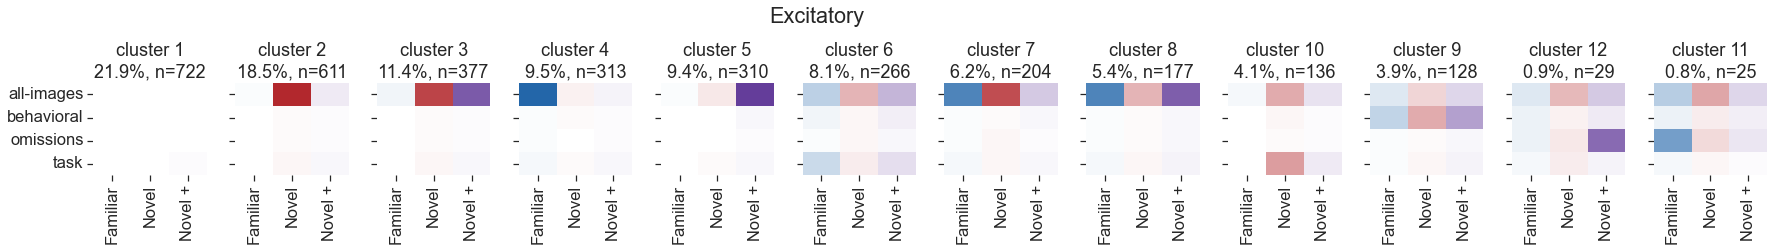

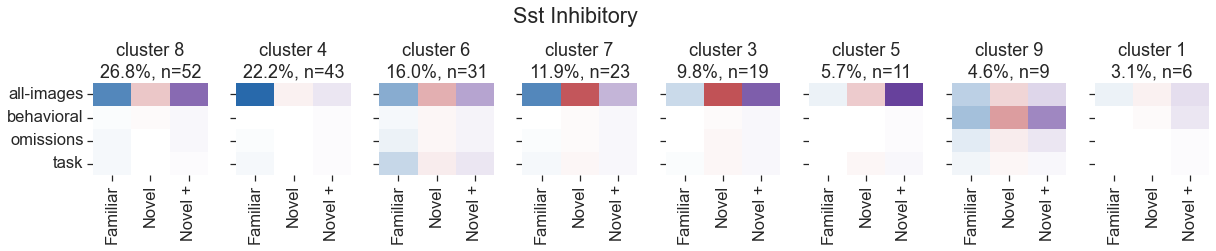

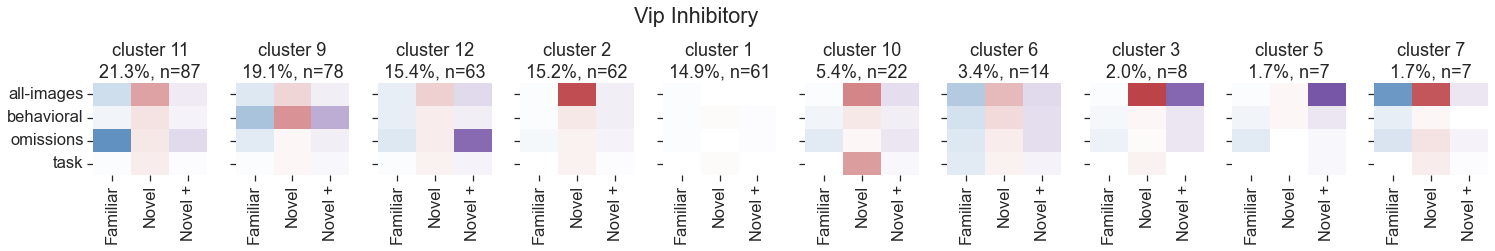

In [16]:
for cre_line in cre_lines:
    cluster_meta_cre = cluster_meta[cluster_meta.cre_line==cre_line]
    clusters = cluster_meta_cre.value_counts('cluster_id').index.values
    plotting.plot_mean_cluster_heatmaps_remapped(original_feature_matrix, cluster_meta_cre, cre_line, clusters, session_colors=True, save_dir=None, folder=None)

#### Load shuffled data

In [56]:
shuffle_dir = os.path.join(save_dir, 'shuffled_files')
n_boots=np.arange(500)
shuffle_type = 'experience'
nb_shuffled = {}
for n_boot in n_boots:
    nb_filename ='all_cells_{}_nb{}.h5'.format(shuffle_type, n_boot)
    feature_matrix = pd.read_hdf(os.path.join(shuffle_dir,nb_filename), key = 'df')
    nb_shuffled[n_boot] = feature_matrix.rename(mapper = {'Novel 1': 'Novel', 'Novel >1': 'Novel +'}, axis=1)
shuffled_feature_matrices = nb_shuffled

In [19]:
len(shuffled_feature_matrices)

500

In [20]:
# to create new shuffled data:
shuffled_matrix_example = processing.shuffle_dropout_score(feature_matrix, shuffle_type='experience', separate_cre_lines=False)

shuffling data across experience


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [63]:
def plot_mean_shuffled_feature_matrix(cre_lines, cluster_meta, shuffled_feature_matrices, n_boots, session_colors=False, experience_index=None, save_dir=None, folder=''):
    if session_colors:
        assert experience_index is None, "session_colors must be False to use experience_index"
    
    fig, ax = plt.subplots(1, len(cre_lines), figsize=(len(cre_lines) * 3, 2.5), sharey='row')
    for c, cre_line in enumerate(cre_lines):
        cluster_meta_cre = cluster_meta[cluster_meta.cre_line == cre_line]
        cids = cluster_meta_cre.index.values
        feature_matrix_cre = None
        for n, n_boot in enumerate(n_boots):
            if n == 0:
                feature_matrix = shuffled_feature_matrices[n]
                feature_matrix_cre = feature_matrix.loc[cids]
            else:
                feature_matrix = shuffled_feature_matrices[n]
                feature_matrix_cre.append(feature_matrix.loc[cids], ignore_index=True)
        
        if session_colors:
            feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix_cre)
        else:
            feature_matrix_remapped = feature_matrix.copy()
            vmax = 1
            remapped_cmap = utils.get_experience_level_cmap()[experience_index]

        mean_feature_matrix = feature_matrix_remapped.mean().unstack()
        features = processing.get_features_for_clustering()
        mean_feature_matrix = mean_feature_matrix.loc[features]
        ax[c] = sns.heatmap(mean_feature_matrix, cmap=remapped_cmap, ax=ax[c], vmin=0, vmax=vmax)
        ax[c].set_title(processing.get_cell_type_for_cre_line(cre_line))
    plt.suptitle('Cell ID shuffle', y=1.1)
    return fig, ax

array([<AxesSubplot:title={'center':'Excitatory'}, xlabel='experience_level'>,
       <AxesSubplot:title={'center':'Sst Inhibitory'}, xlabel='experience_level'>,
       <AxesSubplot:title={'center':'Vip Inhibitory'}, xlabel='experience_level'>],
      dtype=object)

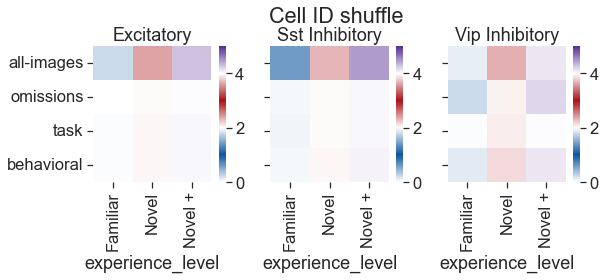

In [65]:
plotting.plot_mean_shuffled_feature_matrix(shuffled_feature_matrices, cluster_meta, session_colors=True, experience_index=None, save_dir=None)


#### Cluster shuffled data

In [ ]:
# example of clustering one shuffled dataset.
# to apply it to multiple shuffled dataset, loop through shuffled_feature_matrices
n_clusters=12 # same as what we have in original data, this can be optimized for each clustering iteration, but would be very time consuming.
sc = SpectralClustering()
X = feature_matrix.values
m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150))
# make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)
cluster_meta = processing.create_and_save_cluster_meta(coclustering_df, n_clusters, feature_matrix, cells_table_matched, cluster_meta_filename)


In [103]:
n_clusters=12

#### Load cluster labels

In [104]:
%%time
## Load shuffled cluster labels
nb_labels_shuffled = {}                       
for n_boot in n_boots:
    nb_filename ='all_cells_{}_nb{}_cluster_labels.h5'.format(shuffle_type, n_boot) 
    full_filename = os.path.join(shuffle_dir, nb_filename)
    nb_labels_shuffled[n_boot] = pd.read_hdf(full_filename, key = 'clustered_df')
shuffled_labels = nb_labels_shuffled

Wall time: 8.97 s


## Compute mean dropout scores for each cluster, each shuffle type, cre_line, and nboot from shuffled dfs

Mean dropout scores are needed for each cluster in order to match original clusters with shuffled

In [114]:
# mean dropout scores for all 12 clusters in each iteration of shuffle for all cell types together
# these averages are what is used to compare shuffled clusters to original clusters when computing SSE

nb_mean_dropout_scores_shuffled = {}
for n, n_boot in enumerate(n_boots):
    cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
    feature_matrix = nb_shuffled[n] # shuffled feature matrix
    mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix, 
                                                      cluster_meta = cluster_meta, stacked=True, max_n_clusters=n_clusters)
    nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores


In [115]:
nb_mean_dropout_scores_shuffled_unstacked = {}
for n, n_boot in enumerate(n_boots):
    cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
    feature_matrix = nb_shuffled[n] # shuffled feature matrix
    mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix, 
                                                      cluster_meta = cluster_meta, stacked=False,max_n_clusters=n_clusters)
    nb_mean_dropout_scores_shuffled_unstacked[n] = mean_dropout_scores

In [106]:
# mean dropout scores for all 12 clusters in each iteration of shuffle separated by cre lines
# This is helpful for plotting clusters for each cre line
cre_mean_dropout_scores_shuffled = {}
for cre_line in cre_lines:
    nb_mean_dropout_scores_shuffled = {}
    for n, n_boot in enumerate(n_boots):
        cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
        cluster_meta_cre  = cluster_meta[cluster_meta.cre_line==cre_line]
        cids = cluster_meta_cre.cell_specimen_id.values
            
        feature_matrix = nb_shuffled[n] # shuffled feature matrix
        feature_matrix_cre = feature_matrix.loc[cids] 
        mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix_cre, 
                                                      cluster_meta = cluster_meta_cre, max_n_clusters=n_clusters)
        nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
    cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled

### panel c and d - SSE matching heatmap 
change color of cluster heatmap

In [107]:
# Compute Sum of Squared Error between original clusters and each iteration of shuffled clusters. 
# Low value indicates better match
SSE_matrix = {}

for n, n_boot in enumerate(n_boots):
    shuffled_mean_dropout_scores = nb_mean_dropout_scores_shuffled[n]
    SSE_matrix[n] = processing.compute_SSE(original_mean_dropout_scores, shuffled_mean_dropout_scores)

# find best matching clusters. If lowest SSE value is above the threshold, no match was found.
SSE_mapping = processing.get_cluster_mapping(SSE_matrix, threshold = 0.1)
    

In [75]:
# decipher shuffle types
shuffle_type_dict = {}
shuffle_type_dict['experience']='cell ID'
shuffle_type_dict['experience_within_cell']='labels'
shuffle_type_dict['full_experience']='both'

In [76]:
def make_dict(matrix):
    new_dict = {}
    keys = np.arange(1, np.shape(matrix)[0]+1)
    for row, key in enumerate(keys):
        new_dict[key] = matrix[row]
    return new_dict

In [110]:
def sort_SSE_values(SSE_matrix, SSE_mapping):
    cre_SSE_all = {}
        
    n_boots = list(SSE_matrix.keys())
    cluster_ids = list(SSE_mapping[0].keys())
        
    # create a data frame to collect sorted SSE from all n_boots
    SSE_matrix_sorted = pd.DataFrame(columns=['cluster_id', *cluster_ids])
        
    # run over all nboots and sort SSE using original cluster sort
    for n in n_boots:
        # Get matched map and SSE matrix for this n boot
        SSE_df = pd.DataFrame(make_dict(SSE_matrix[n]))
        SSE_map = SSE_mapping[n]
            
        # make a copy which will be used to store sorted SSE values
        SSE_df_sorted = SSE_df.copy()
        
        # first sort SSE values
        for i, cluster_id in enumerate(cluster_ids):
            matched_cluster_id = SSE_map[cluster_id] # matched shuffled cluster id
                
            # copy matched SSE value to a new location in df
            if matched_cluster_id != -1:
                SSE_df_sorted.loc[i][:] = SSE_df.loc[matched_cluster_id-1][:].values
            else:
                SSE_df_sorted.loc[i][:] = np.nan # cluster was not matched, mean coding scores are nan
            
            
        # reset index and rename cluster id column
        SSE_df_sorted = SSE_df_sorted.reset_index(drop=True)
        SSE_df_sorted['cluster_id'] = np.arange(1, len(cluster_ids) + 1)
            
        # append to larger df with all n_boots
        SSE_matrix_sorted = SSE_matrix_sorted.append(SSE_df_sorted, ignore_index=True)
    
    return SSE_matrix_sorted

In [111]:
SSE_matrix_sorted = sort_SSE_values(SSE_matrix, SSE_mapping)

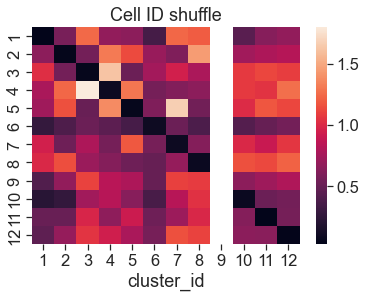

In [113]:
sns.heatmap(np.transpose(SSE_matrix_sorted.groupby('cluster_id').mean()))
plt.title('Cell ID shuffle')
plt.show()

all-images                     omissions                      \
             Familiar     Novel   Novel +  Familiar     Novel   Novel +   
cluster_id                                                                
1            0.008245  0.003125  0.003918  0.003412  0.006359  0.003516   
2            0.026374  0.885535  0.090434  0.009872  0.030257  0.012025   
3            0.080408  0.787501  0.772291  0.011749  0.030253  0.024485   
4            0.912700  0.063783  0.062232  0.027475  0.007509  0.007982   
5            0.027436  0.098206  0.899775  0.010326  0.008291  0.018363   
6            0.304873  0.321134  0.352912  0.047576  0.051155  0.044890   
7            0.725841  0.737746  0.250362  0.034035  0.038424  0.020644   
8            0.722273  0.302357  0.740893  0.028666  0.018656  0.032498   
9            0.149195  0.177314  0.145936  0.071048  0.037982  0.043887   
10           0.044669  0.367929  0.129072  0.020546  0.022731  0.024079   
11           0.224085  0.394340  0.105247  0.637385  0.109848  0.155919   
12           0.115085  0.225764  0.190126  0.131063  0.081760  0.688202   

                task                     behavioral                      
            Familiar     Novel   Novel +   Familiar     Novel   Novel +  
cluster_id                                                               
1           0.002150  0.006699  0.007353   0.007489  0.002918  0.004299  
2           0.010832  0.045034  0.023359   0.009004  0.031560  0.018400  
3           0.016797  0.044318  0.036193   0.009143  0.020873  0.023867  
4           0.041011  0.021859  0.023019   0.023732  0.011571  0.014162  
5           0.013372  0.021541  0.037306   0.007914  0.009790  0.030107  
6           0.229685  0.082826  0.140430   0.071373  0.054951  0.069023  
7           0.055912  0.049027  0.033506   0.024960  0.025498  0.023931  
8           0.042247  0.032020  0.052703   0.024364  0.018608  0.031396  
9           0.029086  0.048292  0.042771   0.308668  0.395623  0.422146  
10          0.017495  0.407519  0.079671   0.017601  0.043198  0.028428  
11          0.031294  0.076533  0.015242   0.075131  0.117091  0.059593  
12          0.032947  0.070935  0.050241   0.094494  0.077583  0.075618

In [273]:
original_cluster_means = plotting.get_cluster_means(original_feature_matrix, original_cluster_meta)
original_cluster_means

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


all-images                     omissions                      \
             Familiar     Novel   Novel +  Familiar     Novel   Novel +   
cluster_id                                                                
1            0.008245  0.003125  0.003918  0.003412  0.006359  0.003516   
2            0.026374  0.885535  0.090434  0.009872  0.030257  0.012025   
3            0.080408  0.787501  0.772291  0.011749  0.030253  0.024485   
4            0.912700  0.063783  0.062232  0.027475  0.007509  0.007982   
5            0.027436  0.098206  0.899775  0.010326  0.008291  0.018363   
6            0.304873  0.321134  0.352912  0.047576  0.051155  0.044890   
7            0.725841  0.737746  0.250362  0.034035  0.038424  0.020644   
8            0.722273  0.302357  0.740893  0.028666  0.018656  0.032498   
9            0.149195  0.177314  0.145936  0.071048  0.037982  0.043887   
10           0.044669  0.367929  0.129072  0.020546  0.022731  0.024079   
11           0.224085  0.394340  0.105247  0.637385  0.109848  0.155919   
12           0.115085  0.225764  0.190126  0.131063  0.081760  0.688202   

                task                     behavioral                      
            Familiar     Novel   Novel +   Familiar     Novel   Novel +  
cluster_id                                                               
1           0.002150  0.006699  0.007353   0.007489  0.002918  0.004299  
2           0.010832  0.045034  0.023359   0.009004  0.031560  0.018400  
3           0.016797  0.044318  0.036193   0.009143  0.020873  0.023867  
4           0.041011  0.021859  0.023019   0.023732  0.011571  0.014162  
5           0.013372  0.021541  0.037306   0.007914  0.009790  0.030107  
6           0.229685  0.082826  0.140430   0.071373  0.054951  0.069023  
7           0.055912  0.049027  0.033506   0.024960  0.025498  0.023931  
8           0.042247  0.032020  0.052703   0.024364  0.018608  0.031396  
9           0.029086  0.048292  0.042771   0.308668  0.395623  0.422146  
10          0.017495  0.407519  0.079671   0.017601  0.043198  0.028428  
11          0.031294  0.076533  0.015242   0.075131  0.117091  0.059593  
12          0.032947  0.070935  0.050241   0.094494  0.077583  0.075618

In [274]:
shuffled_clusters_dict = processing.get_matched_clusters_means_dict(SSE_mapping, nb_mean_dropout_scores_shuffled_unstacked, 
                                                                    metric='mean', shuffle_type=None, cre_line=None) 
for cluster_id in np.arange(1,n_clusters+1):
    if cluster_id==1:
        shuffled_cluster_means = pd.DataFrame(shuffled_clusters_dict[cluster_id].stack()).T
    else:
        shuffled_cluster_means = shuffled_cluster_means.append(pd.DataFrame(shuffled_clusters_dict[cluster_id].stack()).T)
        
shuffled_cluster_means.index = np.arange(1,n_clusters+1)
        
shuffled_cluster_means

regressor        all-images                     behavioral            \
experience_level   Familiar     Novel   Novel +   Familiar     Novel   
1                  0.065139  0.092720  0.093202   0.015334  0.018212   
2                  0.050243  0.818595  0.078009   0.014145  0.028887   
3                  0.067869  0.840688  0.827785   0.017577  0.023992   
4                  0.832334  0.083911  0.098912   0.030807  0.018528   
5                  0.061796  0.078741  0.822865   0.015943  0.018105   
6                  0.324388  0.200189  0.338995   0.115801  0.016435   
7                  0.839611  0.841100  0.127411   0.030725  0.023151   
8                  0.839629  0.326715  0.834848   0.031698  0.030078   
9                  0.000000  0.000000  0.000000   0.000000  0.000000   
10                 0.155557  0.237029  0.202818   0.038745  0.561545   
11                 0.210922  0.338237  0.129197   0.079039  0.106980   
12                 0.116113  0.346718  0.179222   0.065265  0.104983   

regressor                  omissions                          task            \
experience_level   Novel +  Familiar     Novel   Novel +  Familiar     Novel   
1                 0.019065  0.012126  0.016269  0.014326  0.030463  0.041815   
2                 0.018589  0.011929  0.037009  0.014227  0.028813  0.066104   
3                 0.028902  0.013171  0.033167  0.024987  0.031650  0.059826   
4                 0.022138  0.033934  0.015093  0.014010  0.061940  0.037536   
5                 0.029415  0.013037  0.014761  0.025937  0.031553  0.039519   
6                 0.142584  0.038401  0.055053  0.041788  0.046907  0.044075   
7                 0.029162  0.032343  0.034090  0.016354  0.059824  0.058106   
8                 0.027978  0.036271  0.024889  0.029169  0.067535  0.045798   
9                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10                0.045430  0.046255  0.056759  0.041930  0.030277  0.070244   
11                0.075304  0.629748  0.050450  0.090867  0.039415  0.070887   
12                0.075620  0.116368  0.044732  0.683623  0.023676  0.072003   

regressor                   
experience_level   Novel +  
1                 0.033863  
2                 0.032787  
3                 0.049364  
4                 0.035485  
5                 0.049550  
6                 0.047616  
7                 0.035366  
8                 0.047123  
9                 0.000000  
10                0.032181  
11                0.025129  
12                0.049684

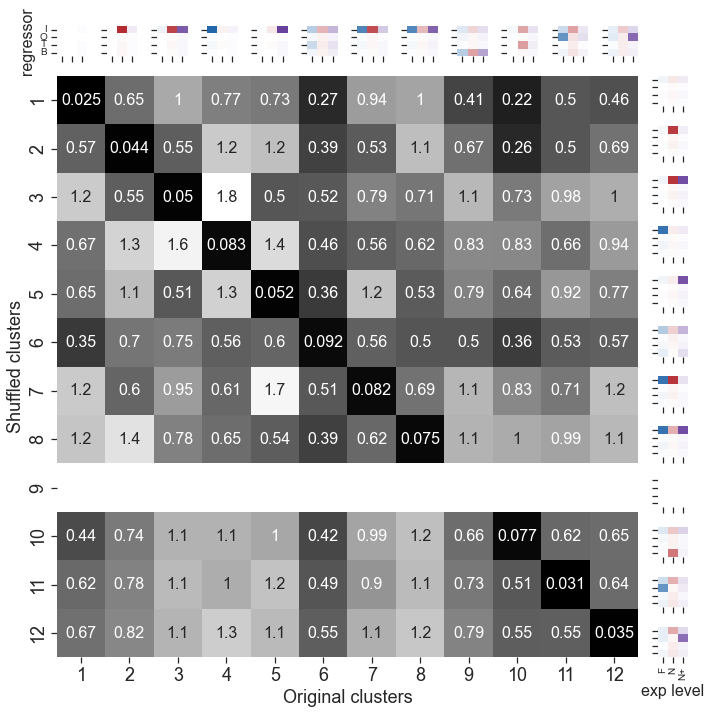

In [272]:

import matplotlib.gridspec as gr
session_colors=True
experience_index =None
     

cluster_ids = cluster_means.columns()
n_clusters = len(cluster_ids)

if session_colors:
    assert experience_index is None, 'Use only one of session_colors or experience_index'
    
if session_colors:
    cluster_means_remapped, coding_score_cmap, vmax = plotting.remap_coding_scores_to_session_colors(cluster_means)
    shuffled_cluster_means_remapped, coding_score_cmap, vmax = plotting.remap_coding_scores_to_session_colors(shuffled_cluster_means)
else:
    cluster_means_remapped = cluster_means.copy()
    shuffled_cluster_means_remapped = shuffled_cluster_means.copy()
    coding_score_cmap = utils.get_experience_level_cmap()[experience_index]
    vmax = 1
    
cluster_means_remapped = cluster_means_remapped.T.copy()
shuffled_cluster_means_remapped = shuffled_cluster_means_remapped.T.copy()

gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))

figsize = (10,10)
fig = plt.figure(figsize = figsize)

            
# plot original
for i, cluster_id in enumerate(cluster_ids):
    ax = fig.add_subplot(gs[0, i])
    ax = sns.heatmap(cluster_means_remapped[cluster_id].unstack().loc[processing.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'T', 'B'],
                cmap = coding_score_cmap, vmin=0, vmax=vmax, cbar=False, ax=ax)
    if i!=0:
        ax.set_yticklabels('')
    else:
        ax.set_ylabel('regressor', fontsize=16)
        ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
    ax.set_xticklabels('')
    ax.set_xlabel('')

# plot shuffled clusters
for i, cluster_id in enumerate(cluster_ids):
    ax = fig.add_subplot(gs[cluster_id, n_clusters])
    ax = sns.heatmap(shuffled_cluster_means_remapped[cluster_id].unstack().loc[processing.get_features_for_clustering()],
            xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'T', 'B'],
            cmap = coding_score_cmap, vmin=0, vmax=vmax,cbar=False, ax=ax)
    ax.set_yticklabels('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    if cluster_id !=n_clusters:
        ax.set_xticklabels('')
    else:
        ax.set_xlabel('exp level', fontsize=16)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)


# Plot SSE
SSE_mean = SSE_matrix_sorted.groupby('cluster_id').mean()        
labels=np.arange(1,len(SSE_mean)+1)
ax = fig.add_subplot(gs[1:,:n_clusters])
ax=sns.heatmap(SSE_mean, annot=True, cmap = 'Greys_r', annot_kws= {"size": 16},
                        yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)

ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
ax.set_ylabel(f'Shuffled clusters', fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
ax.set_xlabel('Original clusters', fontsize=18)

plt.tight_layout()
fig_title=f'mean_SSE_heatmap_all_cells'
utils.save_figure(fig, figsize = figsize, save_dir=save_dir, folder=folder,
                  fig_title=fig_title, formats=['.png'])


In [279]:
original_cluster_means.index.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

TypeError: expected str, bytes or os.PathLike object, not NoneType

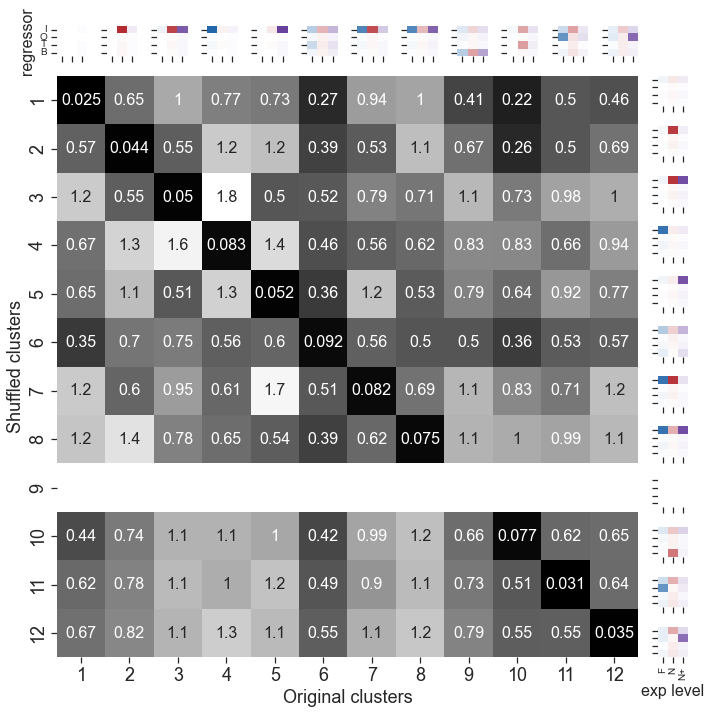

In [281]:
fig = plotting.plot_cluster_heatmaps_with_SSE_matrix(original_cluster_means, shuffled_cluster_means, SSE_matrix_sorted, session_colors=True, experience_index=None, save_dir=None, folder=None)

## panels e and f probability of clusters in shuffled data

In [ ]:

        SSE_mapping = shuffle_type_SSE_mapping[shuffle_type]
        cre_cluster_probabilities = vba_clust.compute_probabilities(SSE_mapping)
        shuffle_type_probabilities[shuffle_type] = cre_cluster_probabilities
    threshold_probabilities[threshold] = shuffle_type_probabilities

# Familiar control

## Supplemental figure 24

In [ ]:
cells_table = processing.get_cells_matched_in_3_familiar_active_sessions()
# add unique identifier for ophys_expt_id + csid pairs so it can be merged with results_pivoted
cells_table['identifier'] = [str(cells_table.iloc[row].ophys_experiment_id)+'_'+str(cells_table.iloc[row].cell_specimen_id) for row in range(len(cells_table))]
cells_table = cells_table.set_index('identifier')

In [ ]:
# add new experience levels for familiar active sessions to results pivoted
# and limit results pivoted to cells matched in 3 familiar sessions
results_pivoted = results_pivoted.drop(columns='experience_level')
results_pivoted = results_pivoted.merge(cells_table[[ 'experience_level']], on='identifier')
results_pivoted.experience_level.unique()

In [ ]:
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))
print(results_pivoted.project_code.unique())
print(results_pivoted.session_type.unique())

In [ ]:
# limit to features used for clustering
features = processing.get_features_for_clustering()
features = ['all-images', 'omissions', 'task', 'behavioral']
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [ ]:
path = r'C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache'

save_dir = os.path.join(path, 'controls')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [ ]:
feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=save_dir)

### gap statistic

In [35]:

metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(save_dir, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_df = pickle.load(f)
        print('loaded file')
else:
    
    sc = SpectralClustering()
    gap_df = processing.compute_gap(clustering=sc, data=feature_matrix, k_max = k_max, 
                                    reference_shuffle=shuffle_type, metric=metric, separate_cre_lines=True)
    processing.save_clustering_results(gap_df, gap_filename)

loaded file


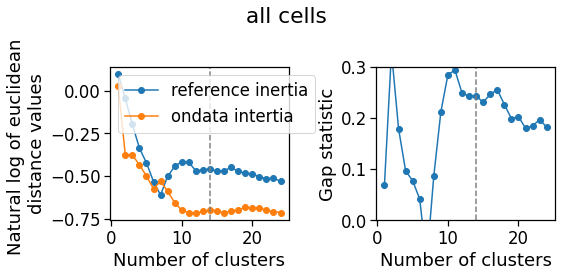

In [36]:

plotting.plot_gap_statistic(gap_df, cre_lines=['all'], n_clusters_cre=10, 
                            tag='with_cre_shuffle', save_dir=None, folder='')

### panel b and c - coclustering matrix

In [ ]:
# number of optimal clusters
n_clusters = 10

coclust_filename = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')

if os.path.exists(coclust_filename):
    coclustering_df = pd.read_hdf(coclust_filename, key='df')
    print('found and loaded cached coclustering matrix file...')
else:
    print('did not find cached coclustering matrix file, will make one...')
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_file = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')
    coclustering_df.to_hdf(coclust_filename, key='df', format='table')
    print('created and saved coclustering_matrix file.')

In [169]:
n_clusters = 10 # based on eigen gap

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    print('loading results')
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
# otherwise run it and save it
else: 
    # run spectral clustering and get co-clustering matrix
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(100))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_path = os.path.join(save_dir, 'coclustering_matrix_n_'+str(n_clusters)+'_clusters.h5')
    coclustering_df.to_hdf(coclust_save_path, key='df', format='table')


    # run agglomerative clustering on co-clustering matrix to identify cluster labels
    from sklearn.cluster import AgglomerativeClustering
    X = coclustering_df.values
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                                    linkage='average')
    labels = cluster.fit_predict(X)
    cell_specimen_ids = coclustering_df.index.values
    # make dictionary with labels for each cell specimen ID in this cre line
    labels_dict = {'labels': labels, 'cell_specimen_id': cell_specimen_ids}
    # turn it into a dataframe
    labels_df = pd.DataFrame(data=labels_dict, columns=['labels', 'cell_specimen_id'])
    # get new cluster_ids based on size of clusters and add to labels_df
    cluster_size_order = labels_df['labels'].value_counts().index.values
    # translate between original labels and new IDS based on cluster size
    labels_df['cluster_id'] = [np.where(cluster_size_order == label)[0][0] for label in labels_df.labels.values]
    # concatenate with df for all cre lines
    cluster_labels = labels_df

    # limit cells_table to cells in feature_matrix and drop duplicates 
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    # cluster_meta will only have one row per cell_specimen_id 

    cluster_meta = cluster_labels[['cell_specimen_id', 'cluster_id', 'labels']].merge(cell_metadata, on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
    cluster_meta['cluster_id'] = cluster_meta['cluster_id'].copy()+1
    # annotate & clean cluster metadata
    cluster_meta = processing.clean_cluster_meta(cluster_meta)  # drop cluster IDs with fewer than 5 cells in them
    cluster_meta['original_cluster_id'] = cluster_meta.cluster_id

    # plot coclustering matrix - need to hack it since it assumes cre lines
    coclustering_dict = {}
    coclustering_dict['all'] = coclustering_df
    cluster_meta_tmp = cluster_meta.copy()
    cluster_meta_tmp['cre_line'] = 'all'
    # plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
    #                                                 save_dir=save_dir, folder=folder, suffix='_'+str(n_clusters)+'_clusters', ax=None)
    
    
    # add within cluster correlation
    cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=True)

    # save clustering results
    print('saving results')
    cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')
    cluster_data = cluster_meta.reset_index()[['cell_specimen_id', 'ophys_experiment_id', 'cre_line', 'cluster_id', 'labels', 'within_cluster_correlation']]
    cluster_data.to_hdf(cluster_meta_save_path, key='df', format='table')


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.69it/s]


1450 cells in cell_metadata for feature_matrix
dropping 1 cells for ('Slc17a7-IRES2-Cre', 10)
dropping 1 cells for ('Slc17a7-IRES2-Cre', 11)
dropping 5 cells for ('Sst-IRES-Cre', 1)
dropping 3 cells for ('Sst-IRES-Cre', 4)
dropping 5 cells for ('Sst-IRES-Cre', 5)
dropping 1 cells for ('Sst-IRES-Cre', 6)
dropping 1 cells for ('Sst-IRES-Cre', 7)
dropping 1 cells for ('Sst-IRES-Cre', 8)
dropping 5 cells for ('Sst-IRES-Cre', 9)
dropping 1 cells for ('Sst-IRES-Cre', 11)
dropping 2 cells for ('Vip-IRES-Cre', 2)
dropping 1 cells for ('Vip-IRES-Cre', 6)
dropping 2 cells for ('Vip-IRES-Cre', 8)
dropping 2 cells for ('Vip-IRES-Cre', 9)
dropping 1 cells for ('Vip-IRES-Cre', 10)
32 cells dropped total
adding within cluster correlation to cluster_meta


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


saving results


### panel d and f - cluster heatmaps

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


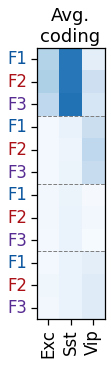

In [163]:
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, session_colors=False, experience_index=0)

In [ ]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, session_colors=False, experience_index=0, save_dir='', folder='', ax=None)

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1649: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if save_dir:


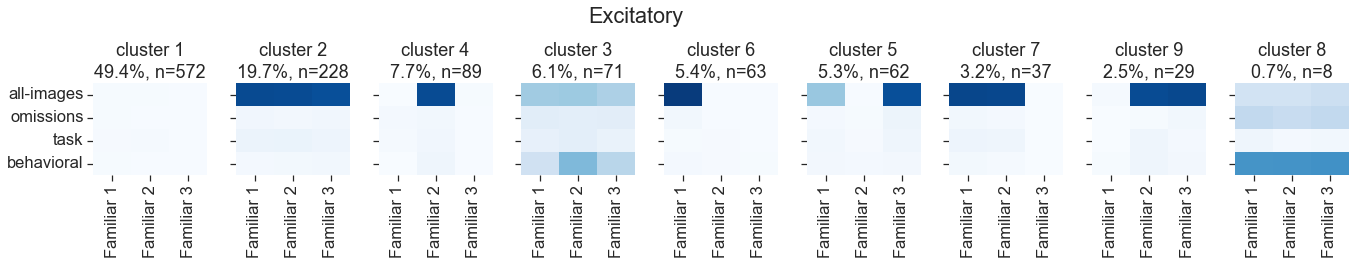

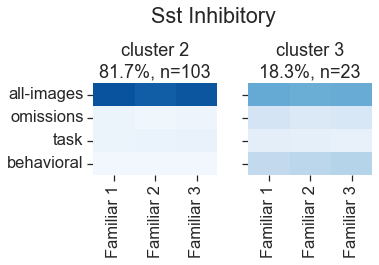

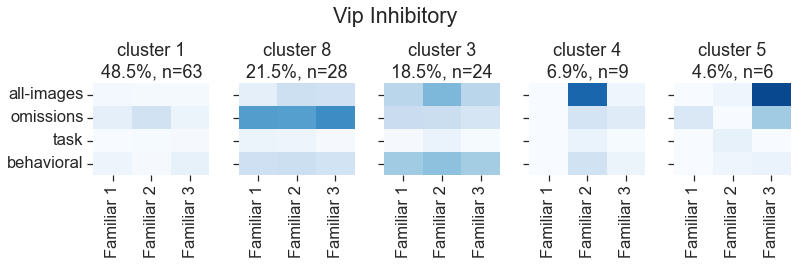

In [198]:
for cre_line in cre_lines:
    cluster_meta_cre = cluster_meta[cluster_meta.cre_line==cre_line]
    clusters = cluster_meta_cre.value_counts('cluster_id').index.values
    plotting.plot_mean_cluster_heatmaps_remapped(feature_matrix, cluster_meta_cre, cre_line, clusters, session_colors=False, experience_index=0, save_dir=None, folder=None)

### Mean response traces for clusters per cre line

In [175]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = ''

In [176]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

change_mdf = multi_session_df[multi_session_df.is_change==True]

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_is_change_.pkl


  6%|████▌                                                                              | 1/18 [00:04<01:22,  4.83s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_G


 22%|██████████████████▍                                                                | 4/18 [00:09<00:29,  2.11s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_B_passive
no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_G_passive


 39%|████████████████████████████████▎                                                  | 7/18 [00:14<00:20,  1.89s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_G
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_A


 61%|██████████████████████████████████████████████████                                | 11/18 [00:20<00:12,  1.72s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_H
no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_A_passive


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:24<00:06,  1.62s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_H_passive
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_A


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:28<00:00,  1.57s/it]


no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_H


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_A


 11%|█████████▏                                                                         | 2/18 [00:01<00:13,  1.19it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_G
no multi_session_df for VisualBehaviorTask1B OPHYS_2_images_A_passive


 28%|███████████████████████                                                            | 5/18 [00:03<00:08,  1.52it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_2_images_G_passive
no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_A


 44%|████████████████████████████████████▉                                              | 8/18 [00:05<00:06,  1.47it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_G


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:07<00:06,  1.22it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_H


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:09<00:03,  1.39it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_5_images_B_passive
no multi_session_df for VisualBehaviorTask1B OPHYS_5_images_H_passive


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]


no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_H


  6%|████▌                                                                              | 1/18 [00:02<00:43,  2.53s/it]

no multi_session_df for VisualBehavior OPHYS_1_images_B
no multi_session_df for VisualBehavior OPHYS_1_images_G


 22%|██████████████████▍                                                                | 4/18 [00:04<00:15,  1.09s/it]

no multi_session_df for VisualBehavior OPHYS_2_images_B_passive
no multi_session_df for VisualBehavior OPHYS_2_images_G_passive


 39%|████████████████████████████████▎                                                  | 7/18 [00:06<00:09,  1.17it/s]

no multi_session_df for VisualBehavior OPHYS_3_images_B
no multi_session_df for VisualBehavior OPHYS_3_images_G
no multi_session_df for VisualBehavior OPHYS_4_images_A


 61%|██████████████████████████████████████████████████                                | 11/18 [00:08<00:04,  1.45it/s]

no multi_session_df for VisualBehavior OPHYS_4_images_H
no multi_session_df for VisualBehavior OPHYS_5_images_A_passive


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:10<00:02,  1.52it/s]

no multi_session_df for VisualBehavior OPHYS_5_images_H_passive
no multi_session_df for VisualBehavior OPHYS_6_images_A


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.45it/s]


no multi_session_df for VisualBehavior OPHYS_6_images_H


 17%|█████████████▊                                                                     | 3/18 [00:00<00:00, 24.66it/s]

no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_2_images_A_passive
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_2_images_B_passive


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:00<00:00, 23.76it/s]

no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_4_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_4_images_B


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:00<00:00, 24.47it/s]

no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_A_passive
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_B_passive
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_6_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_6_images_B


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 24.81it/s]


saving multi session df to pkl
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 1248 experiments after filtering for inclusion criteria -  


In [177]:
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

In [178]:
tmp = multi_session_df.copy()
tmp = tmp[tmp.is_change==False]
# add new experience level to to mdf by merging in cells_table
tmp = tmp.drop(columns='experience_level').merge(cells_table[['cell_specimen_id', 'ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id', 'cell_specimen_id'])
# add cluster_id by merging in cluster meta
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


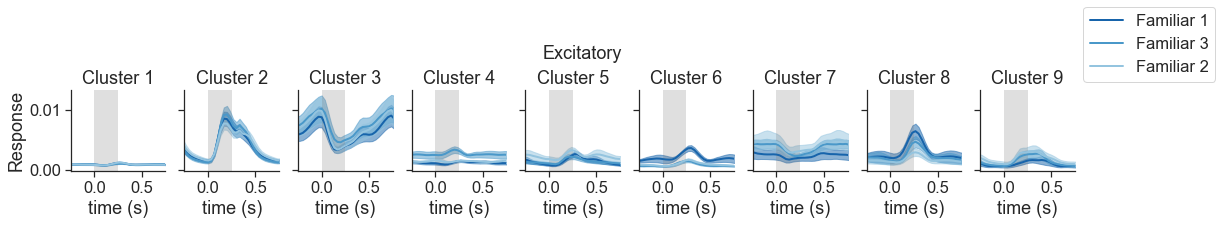

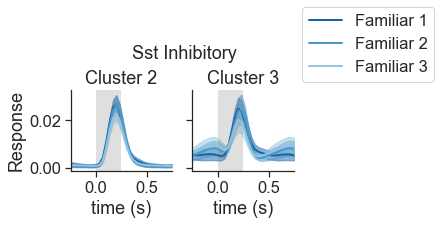

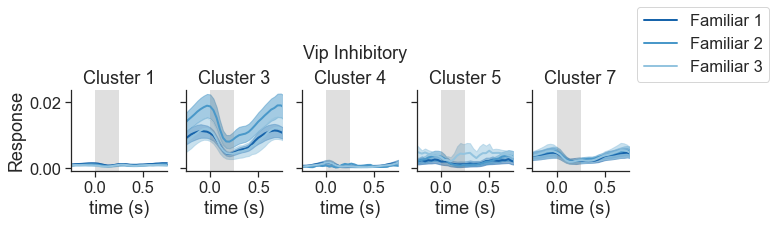

In [256]:
for cre_line in np.sort(tmp.cre_line.unique()):
    df = tmp[tmp.cre_line==cre_line].copy()

    axes_column = 'cluster_id'
    hue_column = 'experience_level'
    # xlim_seconds=[-1., 1.5]
    xlim_seconds=[-0.25, 0.75]
    cell_type = processing.get_cell_type_for_cre_line(cre_line)
    ax= plotting.plot_population_averages_for_clusters(df, event_type, axes_column, hue_column, session_colors=False, experience_index=0,legend=True,
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=cell_type,
                                            save_dir=None, folder='', suffix='_sharey', ax=None);


In [ ]:
### panel e - distribution 

#### Coclustering matrix